# Comparing Confidence Sequences for IID Mean

Comparing CM-EB, Stitching EB, PM-EB, CM-H, Stitching H, PM-H, and Asymptotic CS for IID mean (of differences).

Generally speaking, the order of widths is expected to be (small to large): Asymptotic CS, CM-EB / PM-EB, Stitching EB, CM-H / PM-H, and Stitching H.

In [1]:
import os.path
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

import comparecast as cc

In [2]:
cc.set_theme()

In [3]:
os.makedirs("plots/iid_mean", exist_ok=True)

## Data: IID Differences in Betas

For $i = 1, 2, \dotsc, 10,000$:
$$
D_i \overset{IID}{\sim} \mathrm{Beta}(30, 10) - \mathrm{Beta}(10, 30)
$$

Note that $-1 \leq D_i \leq 1$ a.s., and $\mathbb{E}[D_i] = \frac{30}{30+10} - \frac{10}{10+30} = \frac{1}{2}$.

In [4]:
# setup
alpha = 0.05

# data: Beta(a, b) - Beta(b, a)
a, b = 30, 10  # beta hyperparameters
rng = np.random.default_rng(1)
T = 10000
lo, hi = -1., 1.
xs = rng.beta(a, b, size=T) - rng.beta(b, a, size=T)

# Sample mean (centers)
ts = np.arange(1, len(xs) + 1)
sums = np.cumsum(xs)
mus = sums / ts

# Sample variance (estimate of intrinsic time)
shifted_mus = mus.copy()
shifted_mus[1:], shifted_mus[0] = mus[:-1], mus[0]
vs = np.maximum(1., np.cumsum((xs - shifted_mus) ** 2))

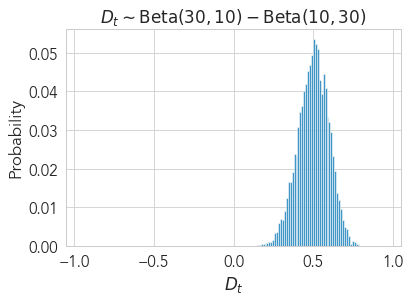

In [5]:
# Plot data, S_t and V_t
df = pd.DataFrame({
    "t": ts,
    "x": xs,
    "s": sums,
    "v": vs,
})

ax = sns.histplot(x="x", stat="probability", data=df)
ax.set(
    title=r"$D_t \sim \mathrm{Beta}(%d, %d) - \mathrm{Beta}(%d, %d)$" % (a, b, b, a),
    xlim=(-1.05, 1.05),
    xlabel=r"$D_t$",
)

plt.savefig("plots/iid_mean/data.pdf")
None

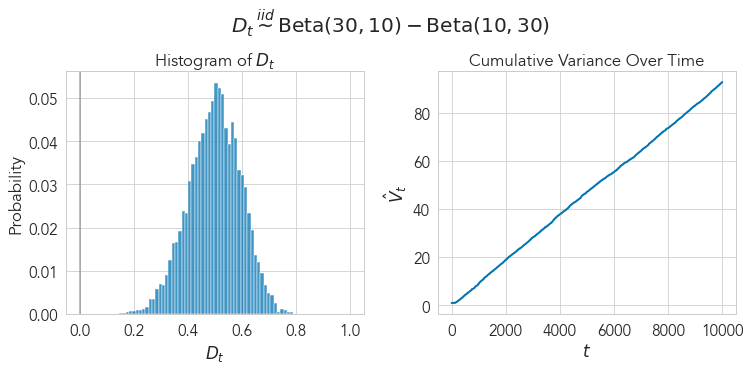

In [6]:
# double plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5), facecolor="white")
sns.histplot(x="x", stat="probability", data=df, ax=ax[0])
ax[0].set(
    xlim=(-0.05, 1.05),
    xlabel=r"$D_t$",
    title=r"Histogram of $D_t$",
)
ax[0].axvline(x=0, linewidth=2, alpha=0.5, color="gray")
sns.lineplot(x="t", y="v", linewidth=2, data=df, ax=ax[1])
ax[1].set(
    #xscale="log",
    #xlim=(10**1, 10**4),
    #yscale="log",
    xlabel=r"$t$",
    ylabel=r"$\hat{V}_t$",
    title=r"Cumulative Variance Over Time",
)

fig.suptitle(r"$D_t \overset{iid}{\sim} \mathrm{Beta}(%d, %d) - \mathrm{Beta}(%d, %d)$" % (a, b, b, a))
fig.subplots_adjust(top=0.8, wspace=0.25)

fig.savefig("plots/iid_mean/data_with_vs.pdf")
None

## Comparing Uniform Boundaries for Empirical Bernstein CS

Given that $\hat{V}_t$ ranges up to $10^3$, we test $v_\mathrm{opt} \in \{0.1, 1, 10, 100, 1000\}$.

In [7]:
df_rows = []
for log_v in [-1, 0, 1, 2, 3]:
    v = 10 ** log_v
    lcbs, ucbs = cc.confseq_eb(xs, alpha, lo, hi, 
                               boundary_type="mixture", v_opt=v)
    df_rows.extend([
        {
            "Time": t, 
            r"$\hat{V}_t$": v_t,
            "Boundary": "Mixture (CM)",
            r"$v_{{opt}}$": v,
            "Width": ucb - lcb,
        }
        for t, (v_t, lcb, ucb) in enumerate(zip(vs, lcbs, ucbs), 1)
    ])

s, eta = 1.4, 2
for log_v in [1]:  # optimal
    v = 10 ** log_v
    lcbs, ucbs = cc.confseq_eb(xs, alpha, lo, hi, 
                               boundary_type="stitching", v_min=v, s=s, eta=eta)
    df_rows.extend([
        {
            "Time": t, 
            r"$\hat{V}_t$": v_t,
            "Boundary": "Stitching",
            r"$v_{{opt}}$": v,
            "Width": ucb - lcb,
        }
        for t, (v_t, lcb, ucb) in enumerate(zip(vs, lcbs, ucbs), 1)
    ])

df = pd.DataFrame(df_rows)
df

,Time,$\hat{V}_t$,Boundary,$v_{{opt}}$,Width
0,1,1.000000,Mixture (CM),0.1,33.891182
1,2,1.000000,Mixture (CM),0.1,16.945591
2,3,1.000000,Mixture (CM),0.1,11.297061
3,4,1.000000,Mixture (CM),0.1,8.472795
4,5,1.000000,Mixture (CM),0.1,6.778236
...,...,...,...,...,...
59995,9996,92.738264,Stitching,10.0,0.011251
59996,9997,92.739428,Stitching,10.0,0.011250
59997,9998,92.761421,Stitching,10.0,0.011250
59998,9999,92.762037,Stitching,10.0,0.011249


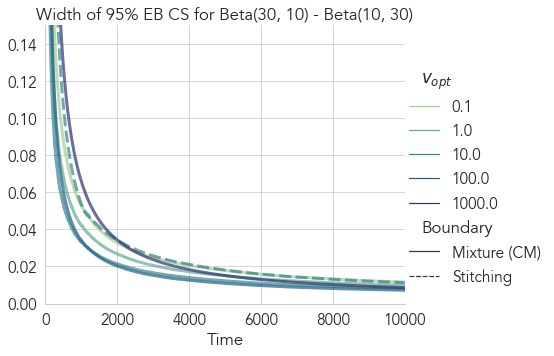

In [8]:
ax = sns.relplot(x="Time", y="Width", kind="line",
                 hue=r"$v_{{opt}}$", hue_norm=matplotlib.colors.LogNorm(),
                 style="Boundary", #col="BoundaryType", 
                 height=5, aspect=1.25, 
                 palette="crest", alpha=0.7, linewidth=3,
                 #facet_kws={"legend_out": False},
                 data=df)
ax.set(
    title=f"Width of {100-100*alpha:g}% EB CS for Beta({a}, {b}) - Beta({b}, {a})",
    # xscale="log",
    # xlim=(10**1, 10**4),
    ylabel="",
    xlim=(0, 10000),
    ylim=(0.0, 0.15),
)

ax.savefig("plots/iid_mean/boundary_comparison.pdf")
None

## Comparison Between Different Confidence Sequences

CM-EB, PM-EB, and Asymptotic CS.

In [9]:
v_opt = 10.

# (cs_type, boundary_type, param_name, param_value, CS)
confseqs = [
    ("EB", "Mixture (CM)", "$v_{{opt}}$", v_opt,
     cc.confseq_eb(xs, alpha, lo, hi, boundary_type="mixture", v_opt=v_opt)),
    ("EB", "Mixture (PM)", "$c$", 0.5,
     cc.confseq_pm_eb(xs, alpha, c=0.5, lo=lo, hi=hi)),
    ("EB", "Stitching", "$v_{{opt}}$", v_opt,
     cc.confseq_eb(xs, alpha, lo, hi, boundary_type="stitching", v_min=v_opt)),
    ("Hoeffding", "Mixture (CM)", "$v_{{opt}}$", v_opt,
     cc.confseq_h(xs, alpha, lo, hi, boundary_type="mixture", v_opt=v_opt)),
    ("Hoeffding", "Mixture (PM)", None, None,
     cc.confseq_pm_h(xs, alpha, lo, hi)),
    ("Hoeffding", "Stitching", "$v_{{opt}}$", v_opt,
     cc.confseq_h(xs, alpha, lo, hi, boundary_type="stitching", v_min=v_opt)),
    ("Asymptotic", "Mixture (CM)", "$t^*$", v_opt,   # some default value
     cc.confseq_asymptotic(xs, alpha, t_star=v_opt, assume_iid=True)),
]

In [10]:
df_rows = []

for cs_type, boundary_type, param_name, param_value, (lcbs, ucbs) in confseqs:
    df_rows.extend([
        {
            "Time": t,
            "CS Type": cs_type,
            "Boundary": boundary_type,
            "LCB": lcb,
            "UCB": ucb,
            "Width": ucb - lcb,
        }
        for t, (lcb, ucb) in enumerate(zip(lcbs, ucbs), 1)
    ])

df = pd.DataFrame(df_rows)
df

,Time,CS Type,Boundary,LCB,UCB,Width
0,1,EB,Mixture (CM),-9.530629,10.641921,20.172551
1,2,EB,Mixture (CM),-4.467727,5.618548,10.086275
2,3,EB,Mixture (CM),-2.792559,3.931625,6.724184
3,4,EB,Mixture (CM),-1.980301,3.062837,5.043138
4,5,EB,Mixture (CM),-1.476655,2.557855,4.034510
...,...,...,...,...,...,...
69995,9996,Asymptotic,Mixture (CM),0.495261,0.502717,0.007455
69996,9997,Asymptotic,Mixture (CM),0.495258,0.502713,0.007455
69997,9998,Asymptotic,Mixture (CM),0.495243,0.502698,0.007455
69998,9999,Asymptotic,Mixture (CM),0.495241,0.502695,0.007454


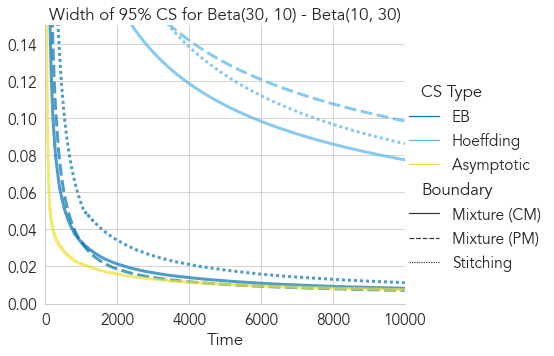

In [11]:
ax = sns.relplot(x="Time", y="Width", hue="CS Type", style="Boundary", kind="line",
                 height=5, aspect=1.25, alpha=0.7, linewidth=3,
                 palette=[cc.get_color_by_index(i) for i in [0, 9, 8]],
                 #facet_kws={"legend_out": False},
                 data=df)
ax.set(
    title=f"Width of {100-100*alpha:g}% CS for Beta({a}, {b}) - Beta({b}, {a})",
    #xscale="log",
    ylabel="",
    xlim=(0, 10000),
    ylim=(0.0, 0.15),
)
#ax._legend._loc = 1
#ax._legend.set_bbox_to_anchor([1, 1])
ax.savefig("plots/iid_mean/cs_comparison.pdf")
None